In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from utils.udp_util import extract_udp_prague_to_dataframe
from utils.plotter import  plot_siftr_graph

In [2]:
# File paths


duration = 120  # Duration in seconds
filename="udp_net_2025-08-07-14-21-30_baseline"




# filename="udp_net_2025-08-07-14-15-15_baseline"

# filename="udp_net_2025-08-07-14-18-07_best"

filename="udp_net_2025-08-07-14-51-01_best"
duration = 1800


file_udp = f'../data/{filename}/udp_prague_receiver_iperf3_d{duration}.json'
file_cubic = f'../data/{filename}/iperf3_client_cubic_iperf3_d{duration}.json'

utf = extract_udp_prague_to_dataframe(file_udp)

from utils.util import create_directory_if_not_exists
import os
graph_directory = os.path.join("./", "Graphs")
create_directory_if_not_exists(graph_directory)


Directory already exists: ./Graphs


In [3]:
import json
import numpy as np
import pandas as pd

def extract_data_df(filename):
    with open(filename) as f:
        data = json.load(f)

    records = []

    for interval in data['intervals']:
        record = {
            'time': interval['sum']['start'],
            'bitrate_mbps': interval['sum']['bits_per_second'] / 1_000_000
        }

        stream = interval['streams'][0]
        if 'rtt' in stream:
            record['rtt_time'] = stream['start']
            record['rtt_ms'] = stream['rtt'] / 1000.0  # µs to ms
        else:
            record['rtt_time'] = None
            record['rtt_ms'] = None

        records.append(record)

    df = pd.DataFrame(records)
    return df


In [4]:
import json
import pandas as pd

def extract_data_df(filename):
    with open(filename) as f:
        data = json.load(f)

    records = []

    for interval in data['intervals']:
        record = {
            'time': interval['sum']['start'],
            'bitrate_mbps': interval['sum']['bits_per_second'] / 1_000_000
        }

        stream = interval['streams'][0]

        # RTT
        if 'rtt' in stream:
            record['rtt_time'] = stream['start']
            record['rtt_ms'] = stream['rtt'] / 1000.0  # µs to ms
        else:
            record['rtt_time'] = None
            record['rtt_ms'] = None

        # Retransmits
        record['retransmits'] = stream.get('retransmits', None)

        # Send congestion window (bytes to KB)
        if 'snd_cwnd' in stream:
            record['snd_cwnd_kb'] = stream['snd_cwnd'] / 1024.0
        else:
            record['snd_cwnd_kb'] = None

        records.append(record)

    df = pd.DataFrame(records)
    return df


In [5]:



# # Function to extract data from iperf3 JSON
# def extract_data(filename):
#     with open(filename) as f:
#         data = json.load(f)

#     times = []
#     bitrates = []
#     rtt_times = []
#     rtts = []

#     for interval in data['intervals']:
#         times.append(interval['sum']['start'])
#         bitrates.append(interval['sum']['bits_per_second'] / 1_000_000)  # Convert to Mbit/s

#         stream = interval['streams'][0]
#         if 'rtt' in stream:
#             rtt_times.append(stream['start'])
#             rtts.append(stream['rtt'] / 1000.0)  # µs to ms

#     return np.array(times), np.array(bitrates), np.array(rtt_times), np.array(rtts)





# import os
# os.path.exists(file_cubic)

# # Extract data
# t_cubic, b_cubic, rt_cubic, rtt_cubic = extract_data(file_cubic)

In [6]:
tfcubic = extract_data_df(file_cubic)

In [7]:
utf.rename(columns={'RTT_ms': 'SmoothedRTT'}, inplace=True)
tfcubic.rename(columns={'rtt_ms': 'SmoothedRTT'}, inplace=True)


utf.rename(columns={'time': 'Time'}, inplace=True)
tfcubic.rename(columns={'time': 'Time'}, inplace=True)


utf.rename(columns={'Rcvd_Mbps': 'thrpt'}, inplace=True)
tfcubic.rename(columns={'bitrate_mbps': 'thrpt'}, inplace=True)


utf.rename(columns={'Lost_Lost': 'Lost_Packets'}, inplace=True)
tfcubic.rename(columns={'retransmits': 'Lost_Packets'}, inplace=True)

In [8]:
tfcubic.describe()

,Time,thrpt,rtt_time,SmoothedRTT,Lost_Packets,snd_cwnd_kb
count,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000
mean,827.500181,131.672157,827.500181,112.762135,4.414251,282.080706
std,478.190308,75.464162,478.190308,456.586172,23.739699,232.177108
min,0.000000,0.000000,0.000000,1.222000,0.000000,1.414062
25%,413.750895,94.377032,413.750895,11.630750,0.000000,185.242188
50%,827.500121,115.336960,827.500121,15.038000,0.000000,226.250000
75%,1241.250186,136.314673,1241.250186,18.384250,0.000000,281.398438
max,1655.000160,618.663564,1655.000160,4506.971000,449.000000,2026.351562


In [9]:
utf.describe()

,Time,thrpt,Sent_Mbps,SmoothedRTT,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Packets,Lost_Total
count,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000
mean,831.600832,99.633565,1.565670,88.657615,1.687994,145.029358,8904.002446,0.341560,0.972477,8904.002446
std,479.429897,42.639976,0.670062,417.019955,4.162644,328.800456,3808.072154,5.970566,6.557987,3808.072154
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,410.685000,83.952000,1.319000,4.960000,0.500000,49.000000,7498.500000,0.000000,0.000000,7498.500000
50%,837.580000,97.677000,1.535000,5.787000,0.990000,93.000000,8723.000000,0.000000,0.000000,8723.000000
75%,1246.150000,112.000000,1.760000,5.988500,1.590000,141.000000,10004.500000,0.000000,0.000000,10004.500000
max,1654.980000,268.753000,4.223000,4280.206000,52.600000,3699.000000,23997.000000,150.000000,126.000000,23997.000000


In [10]:
utf

,Time,thrpt,Sent_Mbps,SmoothedRTT,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Packets,Lost_Total
0,0.00,0.000,0.000,0.000,0.00,0,1,0.0,0,1
1,1.00,8.040,0.127,4.927,0.70,5,719,0.0,0,719
2,2.00,23.250,0.365,5.290,1.01,21,2076,0.0,0,2076
3,3.00,38.118,0.599,5.184,0.59,20,3405,0.0,0,3405
4,4.00,56.839,0.893,5.136,1.00,51,5075,0.0,0,5075
...,...,...,...,...,...,...,...,...,...,...
1630,1650.98,114.080,1.793,4.863,2.60,265,10186,0.0,0,10186
1631,1651.98,100.989,1.587,4.820,0.55,50,9017,0.0,0,9017
1632,1652.98,102.312,1.608,4.905,2.28,208,9135,0.0,0,9135
1633,1653.98,86.446,1.358,5.037,1.50,116,7719,0.0,0,7719


In [11]:
tfcubic

,Time,thrpt,rtt_time,SmoothedRTT,Lost_Packets,snd_cwnd_kb
0,0.000000,217.095905,0.000000,13.060,0,326.648438
1,1.000106,172.023087,1.000106,8.170,0,182.414062
2,2.000102,169.414647,2.000102,12.379,0,251.703125
3,3.000110,142.285388,3.000110,12.993,0,214.937500
4,4.000279,136.075849,4.000279,17.398,0,265.843750
...,...,...,...,...,...,...
1651,1651.000130,115.344164,1651.000130,15.638,0,246.046875
1652,1652.000123,115.347052,1652.000123,13.481,0,199.382812
1653,1653.000091,115.343250,1653.000091,15.672,0,247.460938
1654,1654.000092,125.820571,1654.000092,14.462,0,212.109375


In [12]:
paths = {
    "Cubic": tfcubic,
    "L4S": utf,
}

utf.to_csv("./graph_data/udp_prague_rtt.csv")
tfcubic.to_csv("./graph_data/cubic_rtt.csv")


In [ ]:
import pandas as pd

# Assuming you already have tfcubic loaded
q1 = tfcubic['SmoothedRTT'].quantile(0.25)
q3 = tfcubic['SmoothedRTT'].quantile(0.75)
iqr = q3 - q1

# Define bounds for non-outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
tfcubic_cleaned = tfcubic[(tfcubic['SmoothedRTT'] >= lower_bound) & (tfcubic['SmoothedRTT'] <= upper_bound)]


import pandas as pd

# Assuming you already have utf loaded
q1 = utf['SmoothedRTT'].quantile(0.25)
q3 = utf['SmoothedRTT'].quantile(0.75)
iqr = q3 - q1

# Define bounds for non-outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
utf_cleaned = utf[(utf['SmoothedRTT'] >= lower_bound) & (utf['SmoothedRTT'] <= upper_bound)]


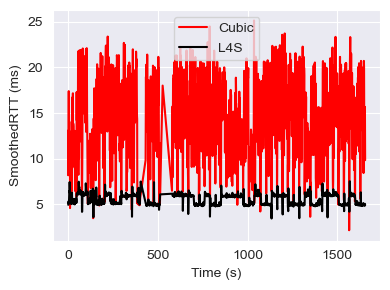

In [15]:
    # Define paths
paths = {
    "Cubic": tfcubic_cleaned,
    "L4S": utf_cleaned,
}


# paths = {
#     "Cubic": tfcubic_filtered_rtt,
#     "L4S": utf_filtered_rtt,
#     "Baseline Propagation Delay": baseline_propagation_delay_df
# }


scenario = str("RTT_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="SmoothedRTT",
                title=f"{scenario} SmoothedRTT",
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

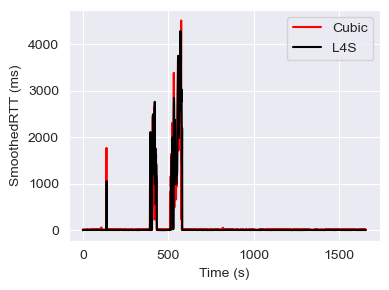

In [16]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "L4S": utf,
}


# paths = {
#     "Cubic": tfcubic_filtered_rtt,
#     "L4S": utf_filtered_rtt,
#     "Baseline Propagation Delay": baseline_propagation_delay_df
# }


scenario = str("RTT_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="SmoothedRTT",
                title=f"{scenario} SmoothedRTT",
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

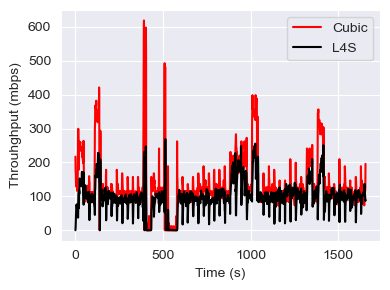

In [17]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "L4S": utf,

}

scenario = str("Thrpt_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="thrpt",
                title=f"{scenario} Throuhghput",
                xlabel="Time (s)",
                ylabel="Throuhghput (mbps)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [18]:
tfcubic[['Time', 'Lost_Packets']].to_csv("./graph_data/cubic_loss.csv", index=False)
utf[['Time', 'Lost_Packets']].to_csv("./graph_data/udp_prague_loss.csv", index=False)


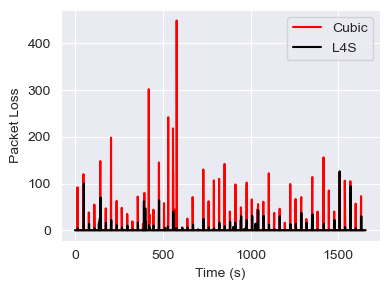

In [19]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "L4S": utf,
    # "Bandwidth": baseline_throuhgput_df
}



scenario = str("PktLoss_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="Lost_Packets",
                title=f"{scenario} Packet Loss",
                xlabel="Time (s)",
                ylabel="Packet Loss",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)